In [1]:
import os
os.chdir('../')

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_columns', None)
import seaborn as sns

In [149]:
indir = Path('drive/output/derived/project_outcomes')

In [150]:
time_period = 6
rolling_window = 732
criteria_col = 'commits'
criteria_pct = 75
consecutive_periods = 3
post_periods = 2
threshold_stat = 0

In [151]:
# key questions
# If we do an event study of each contributor's contributions, what does the pre/post trend look like?
# how does this vary when I change
# -> the outcome
# -> departure metric
# -> pre time period (6, 3)
# -> percentile
# and think about what taking out subsets of people tells us
# how can I validate if people are leaving, and whether their ramping up activity etc


In [152]:
def CleanData(indir, time_period, rolling_window, criteria_col, criteria_pct, consecutive_periods, post_periods, threshold_stat):
    df_unbalanced = pd.read_parquet(indir / f'project_panel_major_months{time_period}_window{rolling_window}D_criteria_{criteria_col}_{criteria_pct}pct_general25pct_consecutive{consecutive_periods}_post_period{post_periods}_threshold_gap_qty_{threshold_stat}.parquet')
    
    df_unbalanced = df_unbalanced[
        (df_unbalanced['time_period'] <= pd.to_datetime("2022-01-01")) &
        (df_unbalanced['time_period'] >= pd.to_datetime("2017-01-01"))
    ]
    repo_names = df_unbalanced['repo_name'].unique()
    time_periods = df_unbalanced['time_period'].unique()
    df = pd.DataFrame(
        pd.MultiIndex.from_product([repo_names, time_periods], names = ['repo_name', 'time_period'])
    )
    df = pd.DataFrame(df[0].tolist(), index=df.index)
    df.columns = ['repo_name','time_period']

    df['time_period'] = pd.to_datetime(df['time_period'])
    df = df.merge(df_unbalanced, on=['repo_name', 'time_period'], how='left').sort_values(['repo_name', 'time_period'])
    df_time_index = df[['time_period', 'time_index']].drop_duplicates().dropna(subset=['time_index'])
    df = df.drop(columns=['time_index'], errors='ignore').merge(df_time_index, on='time_period', how='left')
    
    treated_projects = df.loc[df['treatment'] == 1, 'repo_name'].unique()
    untreated_projects = df.loc[~df['repo_name'].isin(treated_projects), 'repo_name'].unique()
    
    last_preperiod = (
        df[(df['repo_name'].isin(treated_projects)) & (df['treatment'] == 0)]
        .groupby('repo_name', as_index=False)['time_period']
        .max()
        .rename(columns={'time_period': 'period_before_treatment'})
    )
    df = df.merge(last_preperiod, on='repo_name', how='left')
    df['treated_project'] = df['repo_name'].isin(treated_projects).astype(int)
    
    df_full_untreated = df[(df['2017_sample'] == 1) & (df['repo_name'].isin(untreated_projects))]
    mean_active = (
        df[(df['repo_name'].isin(treated_projects)) & (df['treatment'] == 0)]
        .groupby('repo_name', as_index=False)['active_all']
        .mean()
        .rename(columns={'active_all': 'mean_active_pre_treatment'})
    )
    active_treated_repos = mean_active.loc[mean_active['mean_active_pre_treatment'] == 1, 'repo_name'].unique()
    df_full_treated = df[df['repo_name'].isin(active_treated_repos)]
    df_full = pd.concat([df_full_untreated, df_full_treated])

    return df, df_full

In [153]:
df, df_full = CleanData(indir, time_period, rolling_window, criteria_col, criteria_pct, consecutive_periods, post_periods, threshold_stat)

In [155]:
relevant_departures = df.query('treated_project==1')['repo_name'].unique()
relevant_departures_active = df_full.query('treated_project==1')['repo_name'].unique()

In [156]:
# I think I may want to make departed contributors a full expanded panel
# understand why general commits is being fucked up
# understand what's happening with the percentiles
# However, before I do that I want to better understand the dynamics of departure 

In [157]:
time_periods = df_departed['time_period'].sort_values().unique().tolist()

In [158]:
df_departed = df_departed[df_departed['repo_name'].isin(relevant_departures_active.tolist())]

In [159]:
df_bal = df_departed[['repo_name','actor_id']].drop_duplicates()
df_bal['time_period'] = [time_periods for i in range(df_bal.shape[0])]
df_bal = df_bal.explode('time_period')

In [161]:
df_departed['first_period'] = df_departed.groupby(['repo_name','actor_id'])['time_period'].transform('min')
df_full = pd.merge(df_bal, df_departed, how = 'left')
ffill_cols = ['first_period','total_consecutive_periods','final_period','post_final_period']
df_full[ffill_cols] = df_full.groupby(['repo_name','actor_id'])[ffill_cols].ffill()
df_full = df_full.query('time_period >= first_period')
df_full['grouped_index'] = df_full.groupby(['repo_name','actor_id'])['time_period'].transform('cumcount')

"""
df_full = df_full.query('below_qty_mean_gap0==1')
### focusing on below_qty_mean_gap0==1
all_preperiods_mean = df_full.query('time_period <= final_period')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
all_consecutive_preperiods_mean = df_full.query('time_period <= final_period & (final_index - total_consecutive_periods) < grouped_index')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
consecutive_preperiods_mean = df_full.query(f'time_period <= final_period & (final_index - {consecutive_periods}) < grouped_index')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
all_postperiods_mean = df_full.query('time_period > final_period')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
consecutive_postperiods_mean = df_full.query(f'time_period > final_period & (grouped_index - final_index) <= {post_periods}')\
    .groupby(['repo_name','actor_id'])[criteria_col].mean()
"""

"\ndf_full = df_full.query('below_qty_mean_gap0==1')\n### focusing on below_qty_mean_gap0==1\nall_preperiods_mean = df_full.query('time_period <= final_period')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nall_consecutive_preperiods_mean = df_full.query('time_period <= final_period & (final_index - total_consecutive_periods) < grouped_index')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nconsecutive_preperiods_mean = df_full.query(f'time_period <= final_period & (final_index - {consecutive_periods}) < grouped_index')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nall_postperiods_mean = df_full.query('time_period > final_period')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\nconsecutive_postperiods_mean = df_full.query(f'time_period > final_period & (grouped_index - final_index) <= {post_periods}')    .groupby(['repo_name','actor_id'])[criteria_col].mean()\n"

In [165]:
#contribution_histories.query('repo_name == "GeoNode/geonode"').head(60)
df_departed[['repo_name','actor_id']].drop_duplicates()#.query('final_period == time_period')[['repo_name','actor_id']]

,repo_name,actor_id
51,AllenInstitute/AllenSDK,15089451.0
81,AnalogJ/lexicon,891875.0
127,Azure/azure-cli,1329240.0
141,Azure/azure-cli,3630974.0
155,Azure/azure-cli,5019528.0
...,...,...
17822,ytdl-org/youtube-dl,1908898.0
17836,yuma-m/pychord,855763.0
17879,zalando/connexion,610121.0
17893,zalando/patroni,62157128.0


In [31]:
df_all_pre = all_preperiods_mean.reset_index().rename({'commits': f'all_pre_{criteria_col}'}, axis = 1)
df_all_consecutive = all_consecutive_preperiods_mean.reset_index().rename({'commits': f'all_consecutive_pre_{criteria_col}'}, axis = 1)
df_consecutive_pre = consecutive_preperiods_mean.reset_index().rename({'commits': f'consecutive_pre_{criteria_col}'}, axis = 1)
#df_all_post = all_postperiods_mean.reset_index().rename({'commits': f'all_post_{criteria_col}'}, axis = 1)
#df_consecutive_post = consecutive_postperiods_mean.reset_index().rename({'commits': f'consecutive_post_{criteria_col}'}, axis = 1)

df_full = df_full.merge(df_all_pre).merge(df_all_consecutive).merge(df_consecutive_pre)
#df_full = df_full.merge(df_all_post).merge(df_consecutive_post)
df_full[criteria_col] = df_full[criteria_col].fillna(0)

NameError: name 'all_preperiods_mean' is not defined

In [32]:
df_full['relative_time'] = (df_full['grouped_index'] - df_full['final_index'])
normalization_col = f'all_pre_{criteria_col}' #f'all_consecutive_pre_{criteria_col}' #f'consecutive_pre_{criteria_col}'
df_panel = df_full[['repo_name','actor_id','time_period','relative_time',criteria_col,normalization_col,'criteria_exceed']]
df_panel['outcome'] = df_panel[criteria_col]/df_panel[normalization_col]

KeyError: 'final_index'

In [748]:
pre_period = 6
post_period = 3

def DepartureEventStudy(df_panel, pre_period, post_period, enforce_eq_obs = False):
    df_panel = df_panel.copy()
    df_panel['outcome_mean'] = df_panel.groupby('time_period')['outcome'].transform('mean')
    df_panel['outcome'] = df_panel['outcome'] - df_panel['outcome_mean']
    if enforce_eq_obs:
        df_panel['smallest_relative_time'] = df_panel.groupby(['repo_name','actor_id'])['relative_time'].transform('min')
        df_panel['largest_relative_time'] = df_panel.groupby(['repo_name','actor_id'])['relative_time'].transform('max')
        df_panel = df_panel.query(f'smallest_relative_time <= -{pre_period} & largest_relative_time >= {post_period}-1')
    
    sns.lineplot(x='relative_time', y='outcome', data=df_panel.query(f'relative_time >= -{pre_period} & relative_time < {post_period}').reset_index(), errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Event Study Plot of {criteria_col} relative to departure')
    plt.show()

In [33]:
def plot_owner_vs_nonowner_over_time(contribution_histories, repo_name, owner_id, col):
    df_temp = contribution_histories.query(f'repo_name == "{repo_name}"')\
        [[col for col in contribution_histories.columns if 'pct' not in col]]
    df_owner_split = df_temp.assign(owner = df_temp['actor_id'] == owner_id)\
        .drop(['actor_id', 'user_type'], axis = 1)\
        .groupby(['owner','time_period']).sum()\
        .reset_index()
    
    fig, ax = plt.subplots(figsize=(6, 2))

    owner_data = df_owner_split[df_owner_split['owner']]
    ax.plot(owner_data['time_period'], owner_data[col], label='Owner', marker='o')
    
    non_owner_data = df_owner_split[~df_owner_split['owner']]
    ax.plot(non_owner_data['time_period'], non_owner_data[col], label='Non-Owner', marker='o')
    
    ax.set_title(f"{col} Over Time: Owner vs. Non-Owner")
    ax.set_xlabel("Time Period")
    ax.set_ylabel(col)
    ax.legend()
    
    plt.show()

In [ ]:
# Gallopsled/pwntools, 66139157.0, 2020-2022 - looks interesting
# GeoNode/geonode example of robust organization
# KE-works/pykechain,  41430092.0, 2019-2022
# Kinto/kinto, 27856297.0, what's going on 2019-2022??
# MagicStack/uvloop - 2017-2021
# MongoEngine/mongoengine, 173101947.0, 2016-2021


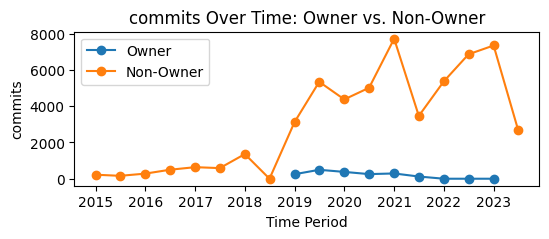

In [117]:
#plot_owner_vs_nonowner_over_time(contribution_histories, "CamDavidsonPilon/lifelines",  884032.0, 'pr')
#plot_owner_vs_nonowner_over_time(contribution_histories, "Flexget/Flexget", 4374581.0, 'commits')
#plot_owner_vs_nonowner_over_time(contribution_histories, "GPflow/GPflow", 5763727.0, 'issue_number')
#plot_owner_vs_nonowner_over_time(contribution_histories, "GoogleCloudPlatform/compute-image-packages", 17957394.0, 'issue_comments')
#plot_owner_vs_nonowner_over_time(contribution_histories, "CartoDB/cartoframes", 2227572, 'commits')
#plot_owner_vs_nonowner_over_time(contribution_histories, "AllenInstitute/AllenSDK", 15089451.0, 'commits')
#plot_owner_vs_nonowner_over_time(contribution_histories, "MongoEngine/mongoengine", 173101947.0, 'commits')
plot_owner_vs_nonowner_over_time(contribution_histories, "Azure/azure-sdk-for-python", 10964656.0, 'commits')

In [95]:
df_departed.head(225).tail(60)

,repo_name,actor_id,time_period,commits,commits_75th_pct,general_commits_25th_pct,criteria_exceed,consecutive_periods,total_consecutive_periods,final_period,post_final_period,sum_post_final_period,first_period,grouped_index,below_qty,first_post_period_index,below_qty_mean_gap0,below_qty_mean_gap1,below_qty_mean_gap2
1201,Kinto/kinto,27856297.0,2023-01-01,0.0,NaN,NaN,NaN,NaN,NaN,2021-01-01,None,NaN,2019-01-01,16,True,13,1.000000,1.00,1.0
1213,Kuniwak/vint,9766.0,2016-07-01,0.0,35.500000,6.312500,0.0,0.0,3.0,2019-07-01,False,1.0,2016-07-01,3,True,10,0.857143,1.00,1.0
1214,Kuniwak/vint,9766.0,2017-01-01,8.0,30.000000,5.650000,0.0,0.0,3.0,2019-07-01,False,1.0,2016-07-01,4,False,10,0.857143,1.00,1.0
1215,Kuniwak/vint,9766.0,2017-07-01,0.0,13.950000,4.600000,0.0,0.0,3.0,2019-07-01,False,1.0,2016-07-01,5,True,10,0.857143,1.00,1.0
1216,Kuniwak/vint,9766.0,2018-01-01,10.0,13.350000,3.800000,0.0,0.0,3.0,2019-07-01,False,1.0,2016-07-01,6,False,10,0.857143,1.00,1.0
1217,Kuniwak/vint,9766.0,2018-07-01,20.0,12.950000,3.000000,1.0,1.0,3.0,2019-07-01,False,1.0,2016-07-01,7,False,10,0.857143,1.00,1.0
1218,Kuniwak/vint,9766.0,2019-01-01,16.0,11.950000,3.000000,1.0,2.0,3.0,2019-07-01,False,1.0,2016-07-01,8,False,10,0.857143,1.00,1.0
1219,Kuniwak/vint,9766.0,2019-07-01,30.0,10.750000,3.000000,1.0,3.0,3.0,2019-07-01,False,1.0,2016-07-01,9,False,10,0.857143,1.00,1.0
1220,Kuniwak/vint,9766.0,2020-01-01,6.0,9.400000,3.000000,0.0,0.0,3.0,2019-07-01,True,1.0,2016-07-01,10,False,10,0.857143,1.00,1.0
1221,Kuniwak/vint,9766.0,2020-07-01,0.0,NaN,NaN,NaN,NaN,NaN,2019-07-01,None,NaN,2016-07-01,11,True,10,0.857143,1.00,1.0


In [761]:
df_panel.head(60)

,repo_name,actor_id,time_period,relative_time,commits,all_pre_commits,criteria_exceed,outcome
0,AllenInstitute/AllenSDK,15089451.0,2017-01-01,-6.0,0.0,185.500000,0.0,0.000000
1,AllenInstitute/AllenSDK,15089451.0,2017-07-01,-5.0,48.0,185.500000,1.0,0.258760
2,AllenInstitute/AllenSDK,15089451.0,2018-01-01,-4.0,132.0,185.500000,1.0,0.711590
3,AllenInstitute/AllenSDK,15089451.0,2018-07-01,-3.0,107.0,185.500000,1.0,0.576819
4,AllenInstitute/AllenSDK,15089451.0,2019-01-01,-2.0,336.0,185.500000,1.0,1.811321
5,AllenInstitute/AllenSDK,15089451.0,2019-07-01,-1.0,490.0,185.500000,1.0,2.641509
6,AllenInstitute/AllenSDK,15089451.0,2020-01-01,0.0,57.0,185.500000,0.0,0.307278
7,AllenInstitute/AllenSDK,15089451.0,2020-07-01,1.0,0.0,185.500000,0.0,0.000000
8,AllenInstitute/AllenSDK,15089451.0,2021-01-01,2.0,0.0,185.500000,NaN,0.000000
9,AllenInstitute/AllenSDK,15089451.0,2021-07-01,3.0,0.0,185.500000,NaN,0.000000


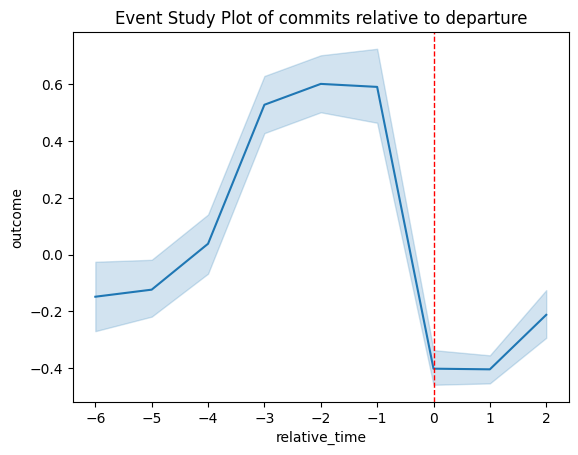

In [753]:
DepartureEventStudy(df_panel, pre_period, post_period)

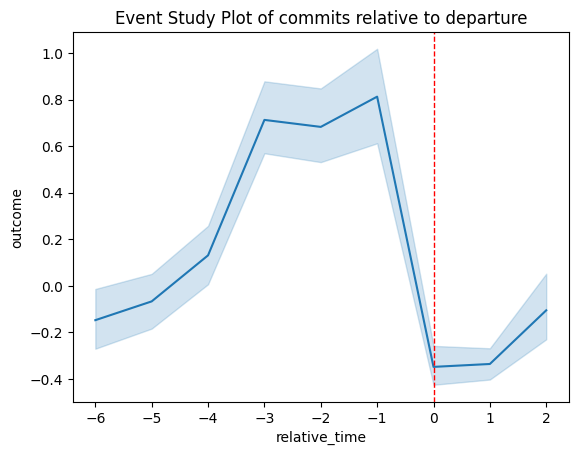

In [754]:
DepartureEventStudy(df_panel, pre_period, post_period, True)

In [628]:
def plot_percentiles_and_mean(df, criteria, plotcols, plotcoldict, month_interval, periods_before, periods_after,
                              window, criteria_pct, pre, post, threshold_mean, nobs, diff = False):
    colname = criteria_dict[criteria]
    
    df_subset = df.query(f'max_periods >= {periods_before}')
    df_actors = df_subset[['actor_id','repo_name','final_period']].drop_duplicates()
    df_actors['start_period'] = df_actors['final_period'].apply(lambda x: x - relativedelta(months = (periods_before-1)*month_interval))
    df_actors['end_period'] = df_actors['final_period'].apply(lambda x: x + relativedelta(months = periods_after*month_interval))
    df_centered = pd.merge(df_subset, df_actors).query('time_period >= start_period & time_period <= end_period')
    df_centered['relative_period'] = (df_centered['time_period'] - df_centered['final_period']).apply(lambda x: round(x.days/30.4)/6)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
    axes = axes.flatten()
    
    for i, plotcol in enumerate(plotcols):
        ax = axes[i]
        
        plotcolname = plotcoldict[plotcol]
        
        percentiles = df_centered.groupby('relative_period')[plotcol].quantile(
            [0.10, 0.50, 0.90]
        ).unstack()
        percentiles_diff = (percentiles - percentiles.loc[-periods_before+1])/percentiles.loc[-periods_before+1] * 100
        
        mean_values = df_centered.groupby('relative_period')[plotcol].mean()
        mean_values_diff = (mean_values - mean_values.loc[-periods_before+1])/mean_values.loc[-periods_before+1] * 100
        difference_str = ""
        if diff == True:
            mean_values = mean_values_diff
            percentiles = percentiles_diff
            difference_str = "% Change from First Pre Period"
        plt.figure(figsize=(10, 6))
        for col in percentiles.columns:
           ax.plot(percentiles.index, percentiles[col], label=f'{(col*100):.1f}th Pct')
        ax.plot(mean_values.index, mean_values, linestyle='-', linewidth=1.5, label='Mean')
        
        ax.axvline(x=1, color='red', linestyle='--')
        ax.set_title(f"Event Study of Percentiles of {plotcolname}")
        ax.set_ylabel(f"{colname}, {difference_str}")
        ax.set_xlabel("Time Relative to Departure", fontsize = 12)
        ax.legend()

    fig.suptitle(f"Obs: {nobs}, Window: {window}D, Criteria: {colname} ({criteria_pct} pct), Pre: {pre}, Post: {post}, Threshold Mean: {threshold_mean}", fontsize = 14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    diff_str = "differenced" if diff else ""
    fig.savefig(Path('issue/departure_eventstudy_plots') / f'contributors_major_months{major_months}_window{window}D_criteria_{criteria}_{criteria_pct}pct_general25pct_consecutive{pre}_post_period{post}threshold_mean_{threshold_mean}_{diff_str}.png')
    plt.show()



In [359]:
indir = Path('drive/output/derived/major_contributor_prospects/departed_contributors')
indir_cov = Path('drive/output/derived/major_contributor_prospects/contributor_data')
indir_hierarchy = Path('drive/output/derived/major_contributor_prospects/contributor_rank_panel')

In [347]:
for criteria_pct in criteria_pct_list:
    df_ic = pd.read_parquet(indir / f'contributors_major_months6_window732D_criteria_issue_comments_{criteria_pct}pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet')
    df_commits = pd.read_parquet(indir / f'contributors_major_months6_window732D_criteria_commits_{criteria_pct}pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet')
    df_ic_indiv = df_ic[['repo_name','actor_id']].drop_duplicates()
    df_commits_indiv = df_commits[['repo_name','actor_id']].drop_duplicates()
    overlapping_indiv = df_ic_indiv.merge(df_commits_indiv)
    print("Criteria PCT: {}, Issue Comment Departures: {}, Commit Departures: {}, Overlap: {}".format(
        criteria_pct, df_ic_indiv.shape[0], df_commits_indiv.shape[0], overlapping_indiv.shape[0]))

Criteria PCT: 75, Issue Comment Departures: 3543, Commit Departures: 704, Overlap: 248
Criteria PCT: 90, Issue Comment Departures: 2344, Commit Departures: 357, Overlap: 131


In [261]:
df_contributor = pd.read_parquet(indir_cov / 'major_contributors_major_months6_window732D_samplefull.parquet')

In [350]:
df_contributor.columns.tolist()

['repo_name',
 'actor_id',
 'time_period',
 'issue_comments',
 'linked_pr_issue_comments',
 'issue_number',
 'linked_pr_issue_number',
 'issue_comments_10th_pct',
 'issue_comments_25th_pct',
 'issue_comments_50th_pct',
 'issue_comments_75th_pct',
 'issue_comments_90th_pct',
 'linked_pr_issue_comments_10th_pct',
 'linked_pr_issue_comments_25th_pct',
 'linked_pr_issue_comments_50th_pct',
 'linked_pr_issue_comments_75th_pct',
 'linked_pr_issue_comments_90th_pct',
 'issue_number_10th_pct',
 'issue_number_25th_pct',
 'issue_number_50th_pct',
 'issue_number_75th_pct',
 'issue_number_90th_pct',
 'linked_pr_issue_number_10th_pct',
 'linked_pr_issue_number_25th_pct',
 'linked_pr_issue_number_50th_pct',
 'linked_pr_issue_number_75th_pct',
 'linked_pr_issue_number_90th_pct',
 'general_issue_comments_25th_pct',
 'general_issue_comments_50th_pct',
 'general_linked_pr_issue_comments_25th_pct',
 'general_linked_pr_issue_comments_50th_pct',
 'general_issue_number_25th_pct',
 'general_issue_number_50th

In [394]:
major_months_list = [6]
window_list = [732] #[367, 732, 1828]
criteria_list = ['issue_comments','commits']
criteria_pct_list = [75, 90]
consecutive_pre = [3] #[3, 6]
consecutive_post = [2] #[2, 4]
threshold_mean_list = [.2] #[.1, .2]
criteria_dict = {'issue_comments':'Issue Comments',
                 'commits':'Commits',
                 #'prs_merged': "PRs Merged",
                 #'issues_closed':"Issues Closed"
                 #'pr': 'PRs Opened',
                 #'pr_reviews': 'PR Reviews',
                 #'push_commits': 'Push Commits',
                 #'pr_commits': 'PR Commits'
                }
plotcols = list(criteria_dict.keys())

for major_months in major_months_list:
    for window in window_list:
        for criteria in criteria_list:
            for criteria_pct in criteria_pct_list:
                for pre in consecutive_pre:
                    for post in consecutive_post:
                        for threshold_mean in threshold_mean_list: 
                            try:
                                df = pd.read_parquet(indir / f'contributors_major_months{major_months}_window{window}D_criteria_{criteria}_{criteria_pct}pct_general25pct_consecutive{pre}_post_period{post}threshold_mean_{threshold_mean}.parquet')
                                df_details = pd.merge(df, df_contributor)
                                df_details['max_periods'] = df_details.groupby(['actor_id','repo_name'])['consecutive_periods'].transform('max')
                                nobs = df_details[['actor_id','repo_name']].drop_duplicates().shape[0]
                                plot_percentiles_and_mean(df_details, criteria, plotcols, criteria_dict, major_months, 5, 3,
                                                          window, criteria_pct, pre, post, threshold_mean, nobs)
                            except Exception as e:
                                print(e)


[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_issue_comments_75pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_issue_comments_90pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_commits_75pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'
[Errno 2] No such file or directory: 'drive/output/derived/major_contributor_prospects/departed_contributors/contributors_major_months6_window732D_criteria_commits_90pct_general25pct_consecutive3_post_period2threshold_mean_0.2.parquet'


In [361]:
df_hierarchy = pd.read_parquet(indir_hierarchy / 'hierarchy_measure_major_months6_window732D.parquet')

<Axes: xlabel='time_period'>

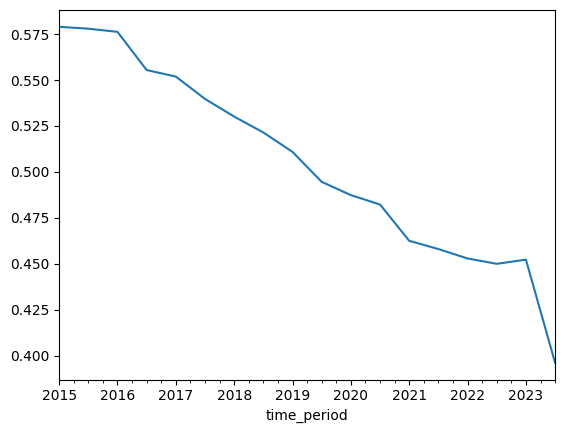

In [366]:
df_hierarchy.groupby('time_period')['project_hierarchy_rank'].mean().plot()

In [370]:
df_hierarchy

,repo_name,time_period,share_opened_issues,share_issue_comments,opened_issues,issue_comments,share_commits,share_pr,commits,pr,opened_issues_hr,issue_comments_hr,commits_hr,pr_hr,project_hierarchy_rank,active_user_hierarchy_rank,developer_hierarchy_rank
0,007gzs/django_restframework_apiview,2019-01-01,1.000000,1.000000,7.0,17.0,0.974359,0.0,39.0,1.0,3.5,1.19,3.9,0.77,0.907051,1.000000,0.813704
1,007gzs/django_restframework_apiview,2020-01-01,0.500000,0.500000,2.0,2.0,NaN,NaN,NaN,NaN,1.0,0.14,NaN,NaN,0.500000,0.500000,NaN
2,007gzs/django_restframework_apiview,2020-07-01,0.000000,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,0.5,0.07,NaN,NaN,0.000000,0.000000,NaN
3,02strich/pykerberos,2015-01-01,0.800000,0.666667,5.0,6.0,0.857143,0.0,7.0,1.0,2.5,0.42,0.7,0.77,0.656036,0.780822,0.408163
4,02strich/pykerberos,2015-07-01,0.500000,0.565217,8.0,23.0,0.937500,0.0,16.0,1.0,4.0,1.61,1.6,0.77,0.552632,0.518717,0.632911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80267,zzzsochi/Flask-Gravatar,2017-01-01,0.666667,0.466667,9.0,15.0,0.000000,0.0,4.0,2.0,4.5,1.05,0.4,1.54,0.465955,0.628829,0.000000
80268,zzzsochi/Flask-Gravatar,2018-01-01,0.000000,0.000000,1.0,1.0,1.000000,1.0,4.0,1.0,0.5,0.07,0.4,0.77,0.672414,0.000000,1.000000
80269,zzzsochi/Flask-Gravatar,2022-07-01,NaN,NaN,0.0,0.0,0.000000,0.0,2.0,1.0,0.0,0.00,0.2,0.77,0.000000,NaN,0.000000
80270,zzzsochi/trans,2015-07-01,1.000000,1.000000,3.0,4.0,NaN,NaN,NaN,NaN,1.5,0.28,NaN,NaN,1.000000,1.000000,NaN


In [392]:
df_hierarchy['project_hierarchy_rank'] = 1 - df_hierarchy['project_hierarchy_rank']

In [393]:
df_hierarchy[['opened_issues','issue_comments','commits','pr','project_hierarchy_rank']].corr().loc[['project_hierarchy_rank']].round(3)

,opened_issues,issue_comments,commits,pr,project_hierarchy_rank
project_hierarchy_rank,-0.057,-0.046,-0.109,-0.087,1.0
